# Suter 2020

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt 
import qutip as q

In [2]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

## Hamiltonian

In [4]:
kwargs = dict(suter_method=True, verbose=False)

C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter (calculated using Suter's dipolar coupling strengths)
register_config = [('NV', (0, 0, 0), 0, {'rotating_frame':True}), ('C13', C13_pos, 0, {})]

hamiltonian = Hamiltonian(register_config, **kwargs)
my_ham = hamiltonian.calc_matrices()[0]
suter_ham =  H_Suter()

print( 'Dennis: ', my_ham )
print( 'Suter: ', suter_ham )

Dennis:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79254.00000013      0.              0.              0.        ]
 [     0.          79254.00000013      0.              0.        ]
 [     0.              0.          -3191.74913584 -55045.04996747]
 [     0.              0.         -55045.04996747   3191.74913584]]
Suter:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79000.      0.      0.      0.]
 [     0.  79000.      0.      0.]
 [     0.      0.  -3000. -55000.]
 [     0.      0. -55000.   3000.]]


## Instant Hadamard (Appendix)

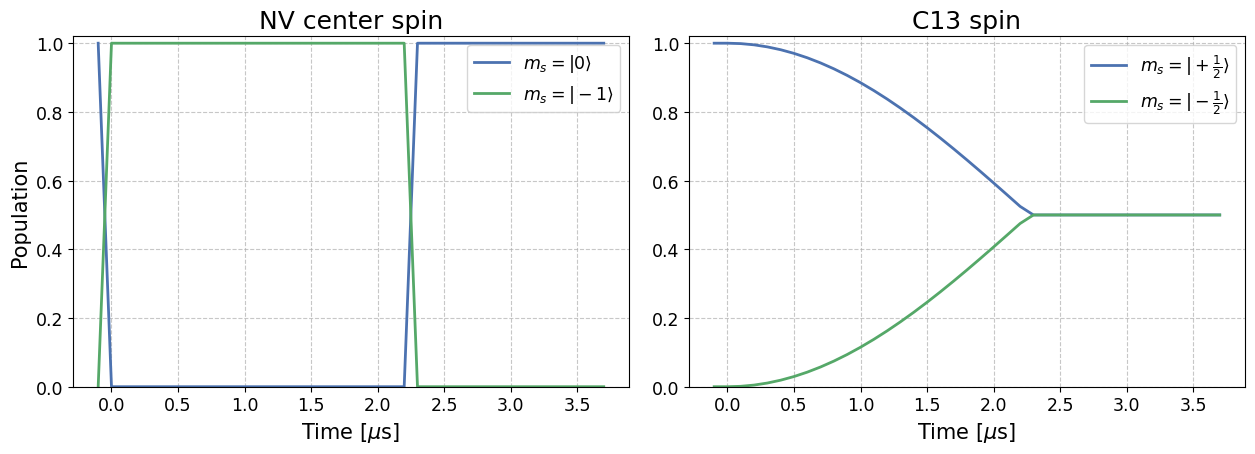

In [5]:
# Analytical times 
C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter (calculated using Suter's dipolar coupling strengths)
T1, T2 = calc_hadamard_pulse_seq(C13_pos, suter_method=True)

# C13 superposition 
NV_state = q.basis(2,0)
C13_state = 1/np.sqrt(2) * ( q.basis(2,0) + q.basis(2,1) )
target = q.tensor(NV_state*NV_state.dag(), C13_state*C13_state.dag())

kwargs = dict(suter_method=True, target=target, verbose=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ('free_evo', dict(t=0)),
    ('inst_rot', dict(alpha=np.pi, phi=0)),
    ('free_evo', dict(t=T1)),
    ('inst_rot', dict(alpha=np.pi, phi=0)),
    ('free_evo', dict(t=T2)),
]

t_list = np.arange(-0.1e-6, (T1+T2), 0.1e-6)
states = env.calc_states(t_list=t_list)[0,:]

fig, ax = plot_pops(t_list, states)

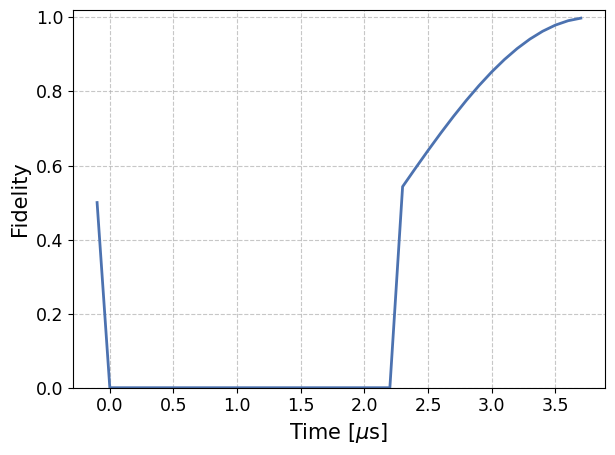

In [6]:
fidelities = env.get_values('fidelity', t_list=t_list)[0,:]
fig, ax = plot_fids(t_list, fidelities)